[20220922]

# 2. Model 1

After Preparation ready. Build and train the model in here. its using two layers LSTM. with data gen1

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import sys
sys.path.insert(1,'../../src/')

## import myfunc inside src folder
# from ramal import eval_model, jampi

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [4]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

In [22]:
%matplotlib inline

## Get Data

In [5]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen1_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [6]:
Xt.shape

(419706, 5, 1)

In [7]:
yt.shape

(419706, 1)

In [8]:
SEQ = Xt.shape[1]

In [9]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

In [10]:
Xo.shape,yo.shape

((39972, 5, 1), (39972, 1))

## Model

In [11]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
mod_ts = Sequential()
# mod_ts.add(LSTM(5, input_shape=(SEQ, 1)))
mod_ts.add(LSTM(128, input_shape=(SEQ, 1), return_sequences=True))
mod_ts.add(LSTM(64))
# mod_ts.add(LSTM(8))
mod_ts.add(Dense(32))
mod_ts.add(Dense(16))
mod_ts.add(Dense(1))


In [14]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model1_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.00065)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [15]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1968/1968 [==============================] - 21s 11ms/step - loss: 0.6792 - the_rmse: 0.8241 - the_mape: 108964.0703 - val_loss: 0.6537 - val_the_rmse: 0.8085 - val_the_mape: 115331.4922
Epoch 2/50
1968/1968 [==============================] - 20s 10ms/step - loss: 0.6458 - the_rmse: 0.8036 - the_mape: 76916.2578 - val_loss: 0.6409 - val_the_rmse: 0.8006 - val_the_mape: 85842.3359
Epoch 3/50
1968/1968 [==============================] - 19s 9ms/step - loss: 0.6336 - the_rmse: 0.7960 - the_mape: 59699.2383 - val_loss: 0.6331 - val_the_rmse: 0.7957 - val_the_mape: 77711.2266
Epoch 4/50
1968/1968 [==============================] - 18s 9ms/step - loss: 0.6294 - the_rmse: 0.7934 - the_mape: 44007.0820 - val_loss: 0.6317 - val_the_rmse: 0.7948 - val_the_mape: 39633.8672
Epoch 5/50
1968/1968 [==============================] - 18s 9ms/step - loss: 0.6272 - the_rmse: 0.7920 - the_mape: 46093.1875 - val_loss: 0.6300 - val_the_rmse: 0.7937 - val_the_mape: 124596.7969
Epoch 6/50
1968/1968

## Eval

<AxesSubplot:>

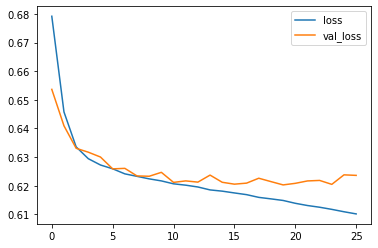

In [23]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [17]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model1_iter3.h5',compile=False)

In [18]:
model_load.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [20]:
model_load.evaluate(x_test,y_test)

3279/3279 [==============================] - 15s 5ms/step - loss: 0.6259 - the_rmse: 0.7911 - the_mape: 95053.3125


[0.6258684396743774, 0.7911185026168823, 95053.3125]

In [21]:
model_load.evaluate(Xo,yo)

1250/1250 [==============================] - 5s 4ms/step - loss: 0.4753 - the_rmse: 0.6894 - the_mape: 118944.1094


[0.47527164220809937, 0.6893994808197021, 118944.109375]